# serial-comm: comunicación y registro de datos por puerto serial
Autor: Claudio Morales D.<br>
https://github.com/cmoralesd/serial-comm <br>
Otoño 2023<br>
<br>
Código base para establecer comunicación por puerto serial entre un dispositivo Arduino (o similar) y un script de Python, utilizando la librería **pyserial**, controlar entradas y salidas del módulo Arduino mediante valores numéricos intercambiados en formato de texto, registrar datos en un archivo CSV, procesar los datos utilizando las herramientas básicas de la librería **pandas** y obtener gráficos de los datos registrados utilizando **matplotlib.pyplot**.

Para comprender las características generales de la comunicación serial, consulte: https://hetpro-store.com/TUTORIALES/puerto-serial/

Los archivos para programación del módulo Arduino se encuentran en https://github.com/cmoralesd/serial-comm


In [2]:
# librerías requeridas
import serial  # librería pyserial, para comunicación con los puertos serial < pip install pyserial >
import time    # para el manejo de eventos de tiempo, nativa de Python
import pandas as pd  # para el manejo de archivos de datos < pip install pandas >
import matplotlib.pyplot as plt # para realizar gráficos < pip install matplotlib >


# funciones para enviar y recibir mensajes en formato de texto, codificado en UTF-8
# los mensajes utilizan como terminador un caracter de final de línea '\n'
def encode_send(ser, texto):
    enc = f'{texto}\n'.encode('UTF-8')
    ser.write(enc)

def decode_response(ser):
    message_from_serial = ser.readline()
    res = message_from_serial[:-1].decode()
    return res


### 1. Código base en esquema request-response

El esquema de comunicación utilizado es **maestro-esclavo** (master-slave) en modo **request-response** (requerimiento-respuesta): sólo un dispositivo puede iniciar la comunicación enviando un requerimiento y el otro dispositivo responde. 

En este caso, el script de Python siempre inicia la comunicación, con un mensaje de texto que contiene dos valores enteros separados por una coma (,). El dispositivo Arduino recibe el mensaje, lo procesa, y envía una respuesta.

El código utilizado en Arduino es: **serial-comm.ino**

In [3]:
# Esquema básico para request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM4', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
val_0 = 123
val_1 = 456
message_to_serial = str(val_0) + ',' + str(val_1)

# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')
print(f'recibido: {message_from_serial}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')


enviado: 123,456
recibido: Arduino OK
el puerto se ha cerrado correctamente


### 2. Enviando mensajes en forma cíclica

El código utilizado en Arduino es: **serial-comm.ino**

In [15]:
serialport.close()

In [16]:
# Esquema básico para comunicarse por puerto serial en forma cíclica
# El código utilizado en Arduino es: serial-comm.ino

# inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM4', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 1 #en segundos

# inicia el ciclo de intercambio de datos


while time_elapsed < time_stop:
    # Preparamos el mensaje a ser transmitido
    val_0 = 0
    val_1 = 0
    message_to_serial = str(val_0) + ',' + str(val_1)

    # enviamos al puerto y esperamos la respuesta
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    # procesamos la respuesta
    print(f'enviado: {message_to_serial}')
    print(f'recibido: {message_from_serial}')

    #actualizar la medición de tiempo
    time_elapsed = time.perf_counter() - time_start
    print(f'tiempo: {time_elapsed}')
    time.sleep(0.2) # en segundos

# cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 0,0
recibido: Arduino OK
tiempo: 0.5449744000006831
enviado: 0,0
recibido: 0;0
tiempo: 0.7915830000001733
enviado: 0,0
recibido: 0;0
tiempo: 1.0263237000008303
el puerto se ha cerrado correctamente


In [22]:
time.perf_counter()

5679.1981578

### 2. Controlando pines I/O en el dispositivo Arduino

El código utilizado en Arduino es: **serial-control.ino**

In [25]:
serialport.close()

In [64]:
# Esquema básico para control de pines I/O en modo request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM4', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
led_verde = 0    # 0 = apagado, otro valor = encendido
led_rojo = 0     # nivel PWM entre 0 y 255
message_to_serial = str(led_verde) + ',' + str(led_rojo)

# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')

data = message_from_serial.split(';')
val_x = int(data[0])
val_y = int(data[1])
print(f'val_x = {val_x}')
print(f'val_y = {val_y}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 0,0
val_x = 511
val_y = 506
el puerto se ha cerrado correctamente


### 4. Registrando datos recibidos desde el puerto serial

El código utilizado en Arduino es: **serial-control.ino**

In [59]:
serialport.close()

In [61]:
# Registro de transacciones vía puerto serial
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicaciones
serialport = serial.Serial('COM4', 9600)
time.sleep(0.1) 
# 2. Inicializa el archivo de registro de datos
filename = 'dataset-' + time.strftime('%d-%m-%y-%H%M%S') + '.csv'
with open(filename, 'w') as file:
    file.write('tiempo,led_verde,led_rojo,val_x,val_y\n')

# 3. Registra las transacciones durante un periodo de tiempo especificado
time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 3. #en segundos

while time_elapsed < time_stop:
    led_verde = 1    # 0 = apagado, otro valor = encendido
    led_rojo = time_elapsed/time_stop + 255 # nivel PWM entre 0 y 255
    message_to_serial = str(led_verde) + ',' + str(led_rojo)

    # 3. Enviamos al puerto y esperamos la respuesta
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    data = message_from_serial.split(';')
    val_x = int(data[0])
    val_y = int(data[1])
    print(f'enviado: {message_to_serial}')
    print(f'recibido: {message_from_serial}')

    with open(filename,'a')as file:
        file.write(str(time_elapsed) + ',' + str(led_verde) + ',' +str(led_rojo) + ',' +str(val_x) + ','+ str(val_y) + '\n')
    time_elapsed = time.perf_counter() - time_start
# 4. Cierra el puerto de comunicaciones
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 1,255.00000953333347
recibido: 0;506
enviado: 1,255.19771433333335
recibido: 512;506
enviado: 1,255.23563086666672
recibido: 1023;506
enviado: 1,255.27416596666657
recibido: 1023;1023
enviado: 1,255.31350899999993
recibido: 1023;1023
enviado: 1,255.3531223333333
recibido: 512;1023
enviado: 1,255.39104999999986
recibido: 512;1023
enviado: 1,255.4298432333335
recibido: 0;1023
enviado: 1,255.46731876666672
recibido: 0;1023
enviado: 1,255.50476013333324
recibido: 512;1023
enviado: 1,255.54270106666658
recibido: 1023;1023
enviado: 1,255.58199163333333
recibido: 1023;1023
enviado: 1,255.62140830000013
recibido: 1023;1023
enviado: 1,255.66083419999995
recibido: 1023;1023
enviado: 1,255.70048256666664
recibido: 641;1023
enviado: 1,255.73949190000016
recibido: 528;1023
enviado: 1,255.7780800666666
recibido: 512;1023
enviado: 1,255.8161875666668
recibido: 512;1023
enviado: 1,255.85404433333346
recibido: 512;506
enviado: 1,255.89213090000007
recibido: 512;506
enviado: 1,255.9300614333333

In [40]:
filename = 'dataset-' + time.strftime('%d-%m-%y-%H:%M:%S') + '.csv'
filename

'dataset-07-06-23-19:14:41.csv'

In [62]:
#ahora graficamos
df = pd.read_csv(filename)
df

,tiempo,led_verde,led_rojo,val_x,val_y
0,0.000029,1,255.000010,0,506
1,0.593143,1,255.197714,512,506
2,0.706893,1,255.235631,1023,506
3,0.822498,1,255.274166,1023,1023
4,0.940527,1,255.313509,1023,1023
5,1.059367,1,255.353122,512,1023
6,1.173150,1,255.391050,512,1023
7,1.289530,1,255.429843,0,1023
8,1.401956,1,255.467319,0,1023
9,1.514280,1,255.504760,512,1023


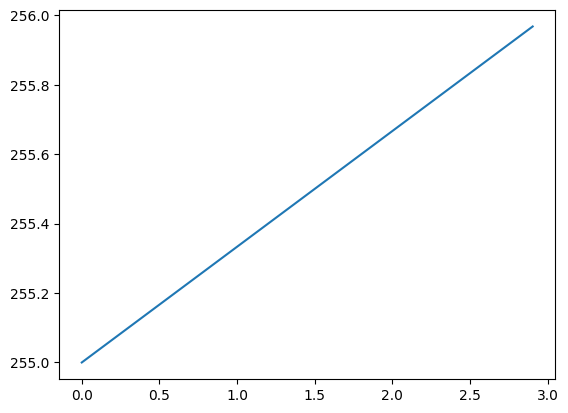

In [63]:
x = df['tiempo'].tolist()
y=df['led_rojo'].tolist()

ax = plt.figure().add_subplot()
ax.plot(x,y)
plt.show()


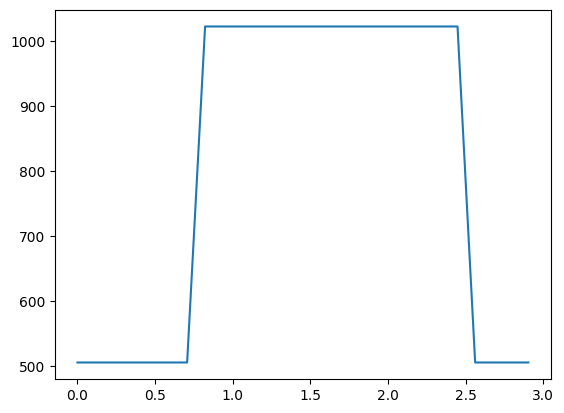

In [65]:
x = df['tiempo'].tolist()
y=df['val_y'].tolist()

ax = plt.figure().add_subplot()
ax.plot(x,y)
plt.show()

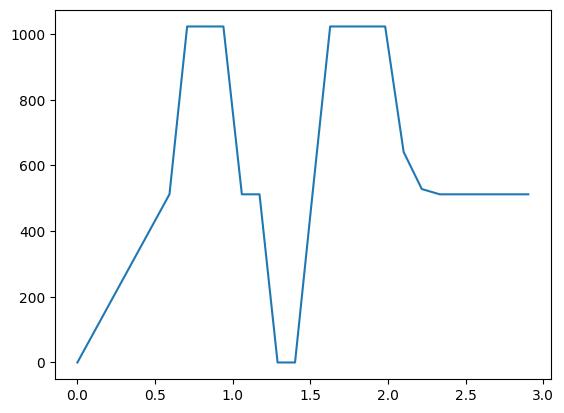

In [66]:
x = df['tiempo'].tolist()
y=df['val_x'].tolist()

ax = plt.figure().add_subplot()
ax.plot(x,y)
plt.show()

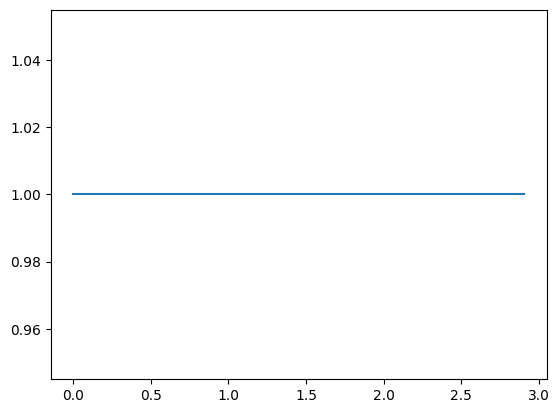

In [67]:
x = df['tiempo'].tolist()
y=df['led_verde'].tolist()

ax = plt.figure().add_subplot()
ax.plot(x,y)
plt.show()